# 基于深度学习的眼部OCT影像分析系统——探索式分析与算法建模

## 依赖包导入

In [1]:
from __future__ import print_function
import tensorflow as tf
from keras import models, layers
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

D:\WorkSpace\MiniConda\envs\myenv\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.6 when it was built against 1.14.5, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


## 解决可视化图像中的中文乱码问题

In [2]:
from matplotlib.font_manager import fontManager
import os
 
fonts = [font.name for font in fontManager.ttflist 
             if os.path.exists(font.fname) and os.stat(font.fname).st_size>1e6]
print(list(fonts))

# 显示中文,解决图中无法显示中文的问题
plt.rcParams['font.sans-serif']=['KaiTi']
 
# 设置显示中文后,负号显示受影响。解决坐标轴上乱码问题
plt.rcParams['axes.unicode_minus']=False

['Calibri', 'STSong', 'HYZhongHei', 'Yu Gothic', 'Calibri', 'Noto Sans SC', 'Ebrima', 'Malgun Gothic', 'SimSun', 'SimSun-ExtG', 'FangSong', 'STXinwei', 'Microsoft YaHei', 'Microsoft JhengHei', 'Segoe UI Variable', 'Cambria', 'STFangsong', 'MS Gothic', 'Calibri', 'Yu Gothic', 'DengXian', 'Malgun Gothic', 'Times New Roman', 'Microsoft JhengHei', 'Noto Sans SC', 'LiSu', 'FZXiaoBiaoSong-B05S', 'YouYuan', 'FZCuHeiSongS-B-GB', 'MingLiU-ExtB', 'Segoe UI Emoji', 'Segoe UI Historic', 'STCaiyun', 'SimHei', 'KaiTi', 'Calibri', 'STXihei', 'FZYaoTi', 'KaiTi_GB2312', 'STHupo', 'Noto Sans SC', 'STZhongsong', 'Source Han Serif SC', 'DengXian', 'Gabriola', 'Calibri', 'Yu Gothic', 'Microsoft JhengHei', 'Microsoft YaHei', 'STKaiti', 'Calibri', 'DengXian', 'FZShuTi', 'FangSong_GB2312', 'Microsoft YaHei', 'SimSun-ExtB', 'Sans Serif Collection', 'Malgun Gothic', 'Arial', 'STLiti', 'Yu Gothic', 'Nirmala UI', 'STXingkai', 'Segoe UI Symbol', 'Times New Roman']


### 使用GPU加速

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


### 1、加载数据集

In [5]:
data_dir = "./dataset/"

data_dir = pathlib.Path(data_dir)

In [6]:
batch_size = 32
img_size = 224

tf.keras.preprocessing.image_dataset_from_directory(  
    directory, #数据所在目录，本项目labels按照默认，所以应该路径应该包含子目录，每个子目录包含一种类型的文件  
    labels="inferred", #标签从目录结构生成，或者是整数标签的列表/元组，本项目中是按照给出的目录结构生成，参数按照默认值  
    label_mode="int", #标签类型：1.int，默认值，标签将被编码成整数，2.categorical：标签将被编码为分类向量 3.binary：二值化标签，值为0或1的float32标量 4.None：无标签  
    class_names=None, #仅当labels为inferred时有效。这是类名称的明确列表（必须与子目录的名称匹配）。用于控制类的顺序（否则使用字母数字顺序）  
    color_mode="rgb",  #grayscale（1通道）、rgb（3通道）、rgba（4通道），默认值：rgb。  
    batch_size=32,  #批次大小  
    image_size=(256, 256),  #读取数据后将其重新调整大小，必要参数。  
    shuffle=True, 	#是否打乱，默认打乱  
    seed=None, #随机种子  
    validation_split=None,  #数据划分，0~1之间，保留验证集  
    subset=None,  #要返回的数据的子集。“训练集”或“验证集”之一。仅当设置了validation_split时才使用。  
    interpolation="bilinear", #当调整图像大小时使用的插值方法  
    follow_links=False,   #是否访问符号链接指向的子目录  
)

### 2、数据预处理

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./dataset/",  #数据集目录
    label_mode="categorical",  #标签模式，根据目录生成
    validation_split=0.20,  # 验证集比例为20%
    subset="training",   #这是个训练集
    seed=42,     #随机种子,保证划分一致  
    image_size=(img_size, img_size),  #图像大小
    batch_size=batch_size
)

Found 10672 files belonging to 6 classes.
Using 8538 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./dataset/",
    label_mode="categorical",
    validation_split=0.20,
    subset="validation",
    seed=42,     #随机种子,保证划分一致 
    image_size=(img_size, img_size),
    batch_size=batch_size)

Found 10672 files belonging to 6 classes.
Using 2134 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['cataract', 'diabetes', 'glaucoma', 'hypertension', 'myopia', 'normal']


### 显示随机图像

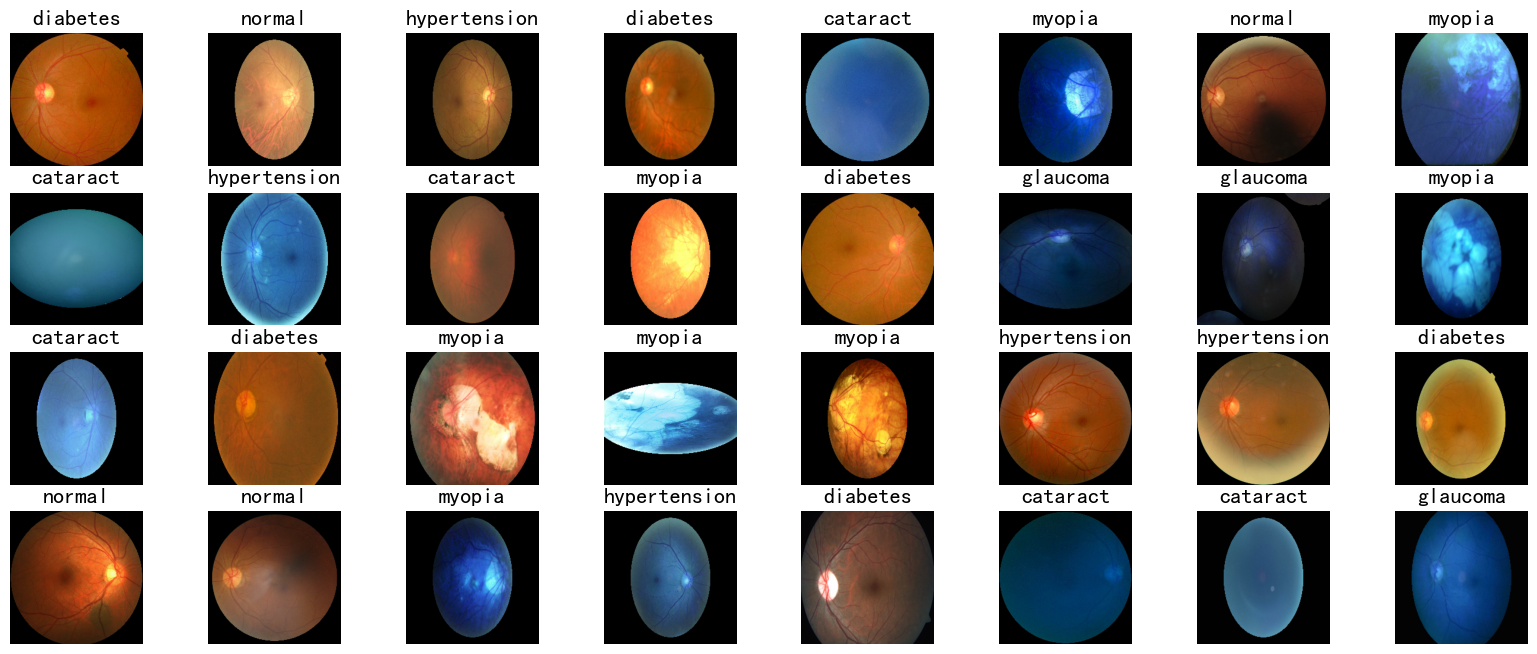

In [10]:
plt.figure(figsize=(20, 10))

for images, labels in train_ds.take(1):
    labels = [tf.argmax(i) for i in labels]  
    for i in range(32):
        ax = plt.subplot(5, 8, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]], fontsize=16)
        plt.axis("off")

**总结**  
1.在shuffle中，buffer size是一个必要的参数，查了一些博客，一般来说都是将buffer size设置为小于数据集大小，即和官方用例相同。（测试1）      
2.尽管官方文档有冲突，但是如果buffer size需要大于数据集，就等于是一个普通的不放回抽样（测试2）  
3.上述二者最明显的区别：测试2中，4和5号球可能会被首次抽中，而测试1则不行。  
4.buffer 不能太小，比如测试3，极端情况下，数据等于没打乱。  
**增加一个buffer的意义：**  
1.数据量足够大时，有了buffer 之后可以增加随机性，随着数据的抽取，buffer 会变得越来越混乱，新的序列也会越来越混乱  
2.还有一个是从打乱数据的储存来着手，即eg1中，第一次取出的2号小球放在哪里，第一种是放在新的数据集的第一个位置，第二种就是放在原数据集的1号位置，即放在盒子A的一号位，因为此时盒子A前三个储存位置是空置的。个人更倾向于第二种情况，因为这样避免了生成一个空置的新序列，也就是说将buffer作为一个置换空间。

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1200).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
# 获取每种疾病数量的列表
train_label_counts = []

for _, labels in train_ds:
    labels = labels.numpy()
    train_label_counts.append(np.sum(labels, axis=0).tolist())
    
valid_label_counts = []

for _, labels in val_ds:
    labels = labels.numpy()
    valid_label_counts.append(np.sum(labels, axis=0).tolist())

In [13]:
label_counts = np.sum(train_label_counts, axis=0) + np.sum(valid_label_counts, axis=0)
label_counts

array([1789., 1805., 1776., 1736., 1764., 1802.])

### 绘制柱状图

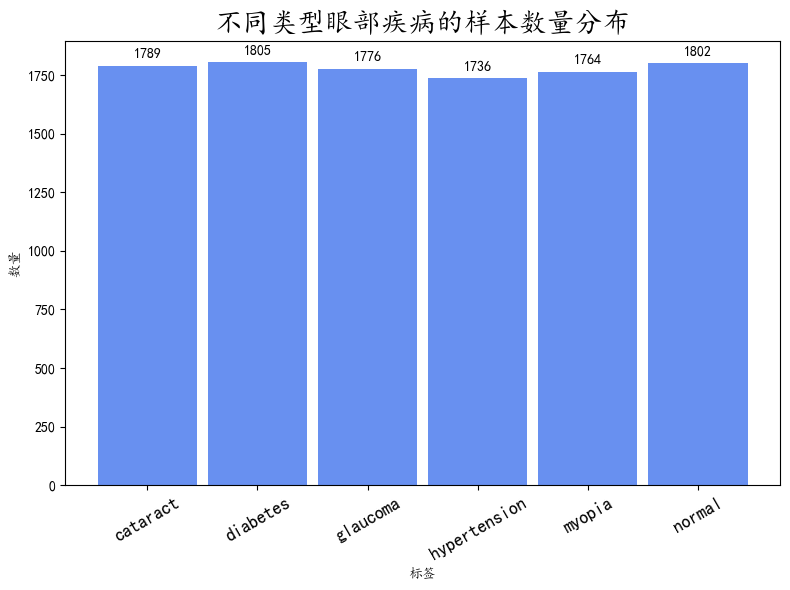

In [14]:
# 创建一个范围，表示 x 轴上每个标签的位置
x = np.arange(len(class_names))

# 设置柱状图的宽度
width = 0.90

# 创建一个新的图形和坐标轴对象
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

# 在坐标轴上绘制柱状图
rects = ax.bar(x, label_counts, width, color='#6890F0')  # 柱状图的颜色设置为 #6890F0

# 设置y轴的标签
ax.set_ylabel('数量')

# 设置x轴的标签
ax.set_xlabel('标签')

# 设置图表的标题
ax.set_title('不同类型眼部疾病的样本数量分布', fontsize=20)

# 设置x轴上的刻度位置，并用标签名称标注
ax.set_xticks(x, class_names, fontsize=13, rotation = 30)

# 在柱状图上添加数值标签
ax.bar_label(rects, padding=4)  # 数值标签与柱子之间留有3的间距

# 调整布局，以避免标题和标签之间的重叠
fig.tight_layout()

# 显示图表
plt.show()

**可以看出，该任务预测类别基本均衡。**

## 3、构建卷积神经网络

### 核心函数
  
**1.models.Sequential()：**   
Sequential()方法是一个容器，描述了神经网络的网络结构，在Sequential()的输入参数中描述从输入层到输出层的网络结构,可以在（）中自定义搭建神经网络的网络结构，类比在桌面上拼积木的话，Sequential()相当于放置积木的桌面。  
  
**2.Conv2D():**   
卷积层，动态提取图片局部特征，  
tf.keras.layers.Conv2D(  
		input_shape = (高, 宽, 通道数), #仅在第一层有  
		filters = 卷积核个数，对应输出的维数  
		kernel_size = 卷积核尺寸，（n，k），如果为一个整数则宽和高相同  
		strides = 卷积横向和纵向的步长,如果为一个整数则横向和纵向相同  
		padding = ‘SAME’ or ‘VALID’,valid:表示不够卷积核大小的块,则丢弃;same表示不够卷积核大小的块就补0,所以输出和输入形状相同  
		activation = ‘relu’ or ‘sigmoid’ or ‘tanh’ or ‘softmax’等   
)  
  
**3.Dropout():**   
drop层，为了减少过拟合。Dropout的机制：在每次的神经网络的反向传播中，会随机选择一些神经元，设定其反向传播对应的参数为0，然后对于被改变后的神经网络进行反向传播，相当于在反向传播时有一些"神经元"被移除了（与L1正则化效果相同）  
主要参数：dropout( rate=丢弃率)  设置为 0.1，则意味着会丢弃 10% 的神经元  
  
**4.MaxPooling2D():**   
layers.MaxPooling2D((2, 2))  
主要参数：pool_size：2个整数的整数或元组/列表：(pool_height,pool_width),用于指定池窗口的大小；可以是单个整数,以指定所有空间维度的相同值.  
平均池化层为AvgPooling2D()  
  
**5.Flatten():** 用于将输入层的数据压成一维的数据  
  
**6.Dense():**	全连接层  
主要参数：    layers.Dense(units, activation),   #全连接层，特征进一步提取  
units：输出的维度大小，即神经元的个数  
activation：激活函数  
  
**7.model.summary():**  打印模型结构

In [21]:
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_size, img_size, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'), # 卷积层1，卷积核3*3
    layers.MaxPooling2D((2, 2)), # 池化层1，2*2采样
    layers.Conv2D(64, (3, 3), activation='relu'), # 卷积层2，卷积核3*3
    layers.MaxPooling2D((2, 2)), # 池化层2，3*3采样
    layers.Conv2D(64, (3, 3), activation='relu'), # 卷积层3，卷积核3*3
    layers.SpatialDropout2D(0.4),  # 更有效的特征图级正则化
    layers.Flatten(), # Flatten层，连接卷积层与全连接层
    layers.Dense(128, activation='relu'), # 全连接层，特征进一步提取
    layers.Dense(len(class_names)) # 输出层，输出预期结果
])

model.build(input_shape=(None, img_size, img_size, 3))
model.summary()  # 打印网络结构

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        3

### **ResNet的核心思想**
传统的深度神经网络在层数增加时，容易遇到梯度消失（vanishing gradient）或梯度爆炸（exploding gradient）问题，导致模型训练变得困难。为了应对这个问题，ResNet引入了残差块（Residual Block），它的关键概念是：对于每一层，网络学习的是残差，即期望的输出与输入之间的差值，而不是直接学习目标输出。残差块通过跳跃连接（skip connection），使得输入直接“跳过”某些层，连接到更深层的输出，从而保留了输入的信息，缓解了深度网络中的梯度问题。
### **残差块（Residual Block）**
每个残差块的结构可以用以下公式表示：**y=F(x,{Wi})+x**。其中：x是残差块的输入，F(x,{Wi})是一组卷积层、激活函数等操作后的输出，代表残差，x被直接加到F(x,{Wi}) 的输出上，形成了最终的输出y。
### **ResNet的基本架构**
ResNet由多个残差块（Residual Blocks）堆叠而成，具有非常深的网络结构。
1. 输入层：通常为224×224×3 的图像。
2. 卷积层 + 最大池化：用来进行特征提取。
3. 残差模块：多个残差块组成的模块。ResNet-50 由 4 个残差模块堆叠而成，每个模块包含不同数量的残差块。
4. 全局平均池化：对每个通道进行池化，输出固定大小的特征图。
5. 全连接层：输出最终的分类结果。
### **ResNet的优点**
解决梯度消失问题：由于跳跃连接允许信息直接传递，ResNet在训练深层网络时不容易出现梯度消失的问题，可以训练非常深的网络。  
有效利用深度网络：传统的深度网络可能由于训练困难，无法有效利用深度带来的优势。而ResNet通过残差学习有效地利用了深度网络的优势，获得了更好的表现。  
参数共享：由于每个残差块只需要学习输入与输出之间的残差，ResNet模型能有效地减少计算量和参数数量。  
较好的泛化能力：由于通过跳跃连接保持了信息流动，ResNet在一些任务上展现出了较强的泛化能力。

## CNN与ResNet的区别
CNN是卷积神经网络，主要用于图像识别、目标检测和语音识别等任务。而ResNet是残差网络，是一种在CNN基础上的变体，通过引入残差块来训练更深层次的神经网络。
### 模型结构
CNN主要由卷积层、池化层和全连接层组成。在传统的CNN中，信息从输入一直通过各个层向前传播，而ResNet则在传统CNN基础上增加了残差块，在ResNet中，每个残差块包含了多个卷积层
和一条跨过若干层的“捷径”（shortcut connection），使得信息可以直接从前面的某一层传到后面的某一层。这种设计避免了深层网络训练时的梯度消失问题，并且使得网络更易于训练。
### 训练效果
ResNet相比传统的CNN，在图像识别、目标检测等任务中取得了更好的性能。由于残差块的使用，ResNet可以训练更深的神经网络，例如ResNet-50就有50个卷积层，而且在训练误差和测试误差上都表现出了更好的性能。
### 使用深度CNN架构重新训练
使用上述自己构建的CNN模型在训练过程中发现数据过拟合现象有一些严重，得出的模型AUC比预计要低很多  
于是采用残差神经网络，由于keras中没有直接提供ResNet18模型，那就手动构建一个

In [15]:
def resnet18(input_shape, num_classes):

    inputs = layers.Input(shape=input_shape)
    x = layers.ZeroPadding2D(padding=(3, 3))(inputs)
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding2D(padding=(1, 1))(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    # ResNet18 的基本模块
    def basic_block(filters, strides=1, downsample=None):
        def block(x):
            identity = x
            if downsample is not None:
                identity = downsample(x)
            x = layers.Conv2D(filters, (3, 3), strides=strides, padding='same', use_bias=False)(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation('relu')(x)
            x = layers.Conv2D(filters, (3, 3), padding='same', use_bias=False)(x)
            x = layers.BatchNormalization()(x)
            x = layers.Add()([x, identity])
            x = layers.Activation('relu')(x)
            return x
        return block

    # 第一层
    x = basic_block(64, strides=1)(x)
    x = basic_block(64, strides=1)(x)

    # 第二层
    downsample = models.Sequential([
        layers.Conv2D(128, (1, 1), strides=(2, 2), use_bias=False),
        layers.BatchNormalization()
    ])
    x = basic_block(128, strides=2, downsample=downsample)(x)
    x = basic_block(128, strides=1)(x)

    # 第三层
    downsample = models.Sequential([
        layers.Conv2D(256, (1, 1), strides=(2, 2), use_bias=False),
        layers.BatchNormalization()
    ])
    x = basic_block(256, strides=2, downsample=downsample)(x)
    x = basic_block(256, strides=1)(x)

    # 第四层
    downsample = models.Sequential([
        layers.Conv2D(512, (1, 1), strides=(2, 2), use_bias=False),
        layers.BatchNormalization()
    ])
    x = basic_block(512, strides=2, downsample=downsample)(x)
    x = basic_block(512, strides=1)(x)

    # 全局平均池化和全连接层
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, x)
    return model

# 创建 ResNet18 模型
model = resnet18(input_shape=(img_size, img_size, 3), num_classes=len(class_names))

# 打印模型结构
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

### 模型编译

In [16]:
initial_learning_rate = 1e-3

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, #设置初始学习率
        decay_steps=64,      #每隔多少个step衰减一次
        decay_rate=0.94,     #衰减系数
        staircase=True
)

# 将指数衰减学习率送入优化器
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
 
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## 保存最佳参数、设置过早停

## 设置 early_stop 过早停  
使用早停可以节约训练时间、防止可能发生的过拟合（训练次数太多，拟合到了噪声）  
**1）函数调用及[说明](https://tensorflow.google.cn/api_docs/python/tf/keras/callbacks/EarlyStopping?hl=en)**  
tf.keras.callbacks.EarlyStopping(  
    monitor='val_loss',  
    min_delta=0,  
    patience=0,  
    verbose=0,  
    mode='auto',  
    baseline=None,  
    restore_best_weights=False  
)

**2）EarlyStopping()参数说明：**  
  
● monitor: 被监测的指标数值，即选择一个评价指标，本项目中选择的时验证集的acc  
● min_delta: 在被监测的数据中被认为是提升的最小变化， 例如本项目中，min_delta=0.001，即验证集acc的绝对变化小于0.001，会被认为没有提升。  
● patience: 没有进步的训练轮数，在这之后训练就会被停止，patient不宜设置过小，防止因为一些局部震荡导致过早停止训练，无法取得最优解。当然，设置的过大，EarlyStopping的意义就没了。比如下面设置为30个epochs之后没有变化就会停止训练。  
● verbose: 详细信息模式。默认为0，选择1将在回调执行操作时显示消息。  
● mode: {auto, min, max} 其中之一。 在 min 模式中， 当被监测的数据停止下降，训练就会停止；在 max 模式中，当被监测的数据停止上升，训练就会停止；在 auto 模式中，方向会自动从被监测的数据的名字中判断出来。比如监听loss就会按照下降，acc就会按照上升。  
● baseline: 要监控的数量的基准值。 如果模型没有显示基准的改善，训练将停止。  
● restore_best_weights: 是否从具有监测数量的最佳值的时期恢复模型权重。 如果为 False，则使用在训练的最后一步获得的模型权重。设置为True，则自动查找最优的monitor指标时的模型参数进行恢复。  
  
## 保存最优模型  
1）函数及参数  
tf.keras.callbacks.ModelCheckpoint(  
    filepath,  #文件地址及名称  
    monitor: str = 'val_loss', #监控指标  
    verbose: int = 0,  #是否打印信息，0是否，1是打印  
    save_best_only: bool = False,  #仅保存最优  
    save_weights_only: bool = False,  #仅保存权重  
    mode: str = 'auto',  
    save_freq='epoch',  每个几个epoch保存一次  
    options=None,  
    initial_value_threshold=None,  
    **kwargs  
)

In [17]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
 
epochs = 100
 
# 保存最佳模型参数
checkpointer = ModelCheckpoint('best_model.h5',
                                monitor='val_accuracy',
                                verbose=1,
                                save_best_only=True)
 
# 设置早停
earlystopper = EarlyStopping(monitor='val_accuracy',
                            min_delta=0.002,
                            patience=5,
                            verbose=1,
                            restore_best_weights=True)

## 模型训练

In [18]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    callbacks=[checkpointer, earlystopper]
)

Epoch 1/100


D:\WorkSpace\MiniConda\envs\myenv\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


267/267 [==============================] - ETA: 0s - loss: 1.3356 - accuracy: 0.5068   
Epoch 1: val_accuracy improved from -inf to 0.34911, saving model to best_model.h5
267/267 [==============================] - 24s 76ms/step - loss: 1.3356 - accuracy: 0.5068 - val_loss: 3.1754 - val_accuracy: 0.3491
Epoch 2/100
267/267 [==============================] - ETA: 0s - loss: 1.0037 - accuracy: 0.6115 
Epoch 2: val_accuracy improved from 0.34911 to 0.61996, saving model to best_model.h5
267/267 [==============================] - 19s 72ms/step - loss: 1.0037 - accuracy: 0.6115 - val_loss: 1.0076 - val_accuracy: 0.6200
Epoch 3/100
267/267 [==============================] - ETA: 0s - loss: 0.7926 - accuracy: 0.6904 
Epoch 3: val_accuracy improved from 0.61996 to 0.63777, saving model to best_model.h5
267/267 [==============================] - 19s 72ms/step - loss: 0.7926 - accuracy: 0.6904 - val_loss: 0.8575 - val_accuracy: 0.6378
Epoch 4/100
267/267 [==============================] - ETA: 0s

## 4、模型训练 metric 绘制

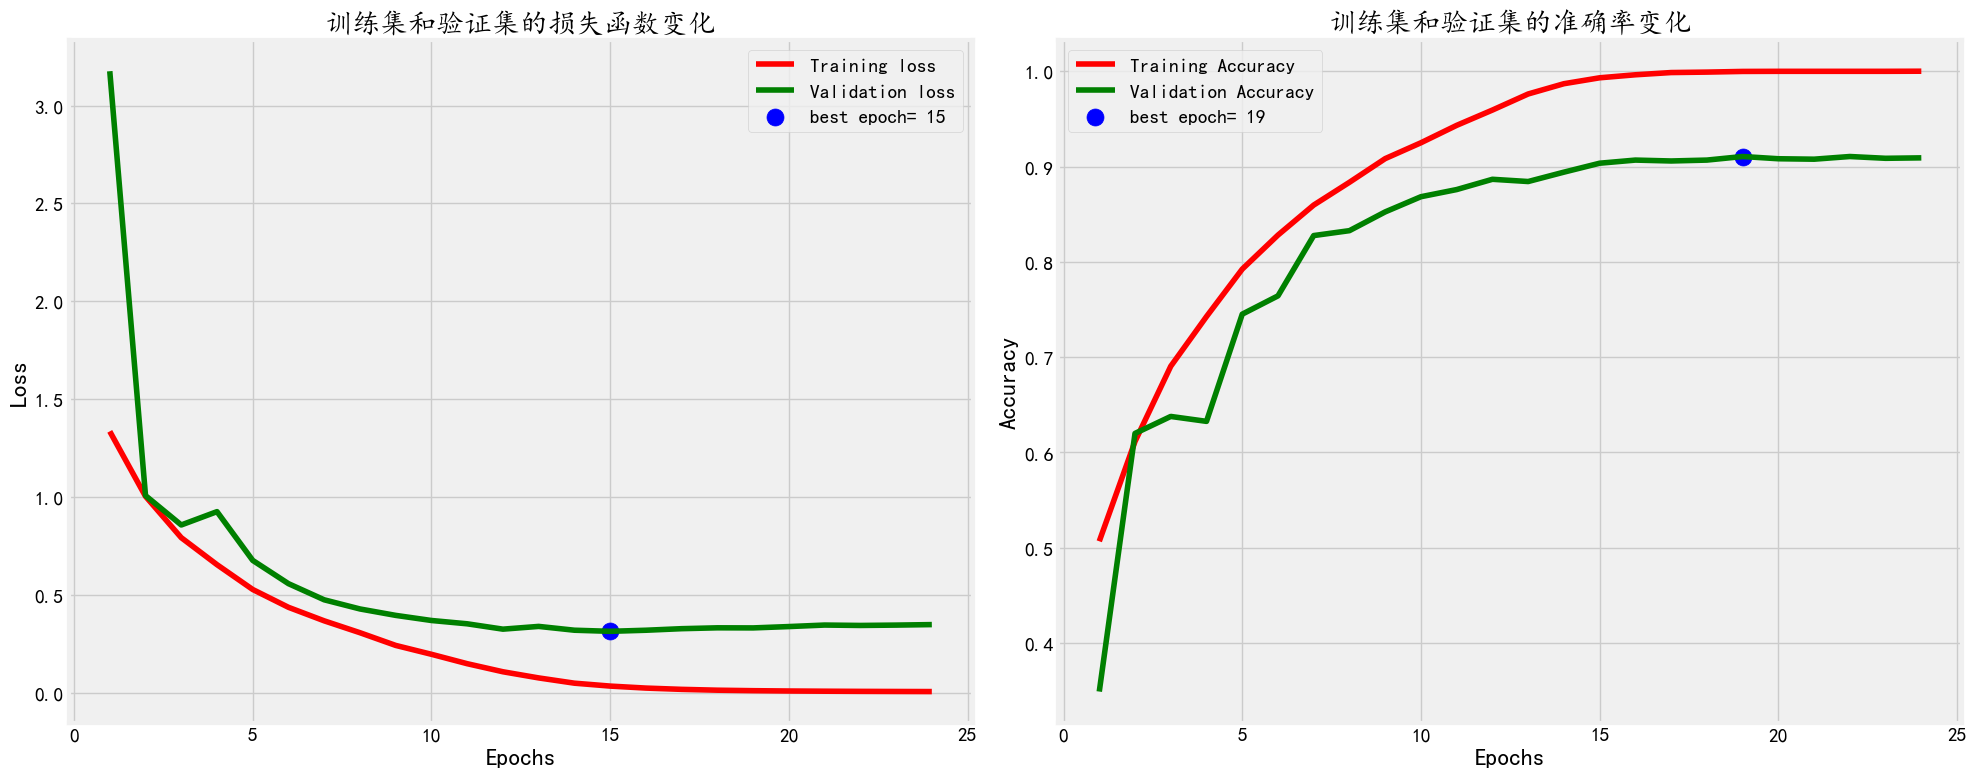

In [19]:
# 获取训练和验证的损失及准确率
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('训练集和验证集的损失函数变化')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('训练集和验证集的准确率变化')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### 验证集预测性能评估

In [20]:
from sklearn.metrics import roc_auc_score

pred_test = model.predict(val_ds)

67/67 [==============================] - 2s 21ms/step


In [21]:
val_labels = []

for _, labels in val_ds:
    batch_labels = labels.numpy()
    for labels in batch_labels:
        val_labels.append(labels.tolist())
        
val_labels = np.array(val_labels)

In [22]:
roc_sum = 0
cate_auc = []
for i in range(6):
    score = roc_auc_score(val_labels[:, i], pred_test[:, i])
    cate_auc.append(score)
    roc_sum += score
    print(f'{class_names[i]} AUC: {score:.4f}')

roc_sum /= 6
print(f'模型预测平均 AUC:{roc_sum:.3f}')

cataract AUC: 0.9928
diabetes AUC: 1.0000
glaucoma AUC: 0.9755
hypertension AUC: 0.9890
myopia AUC: 0.9993
normal AUC: 0.9803
模型预测平均 AUC:0.989


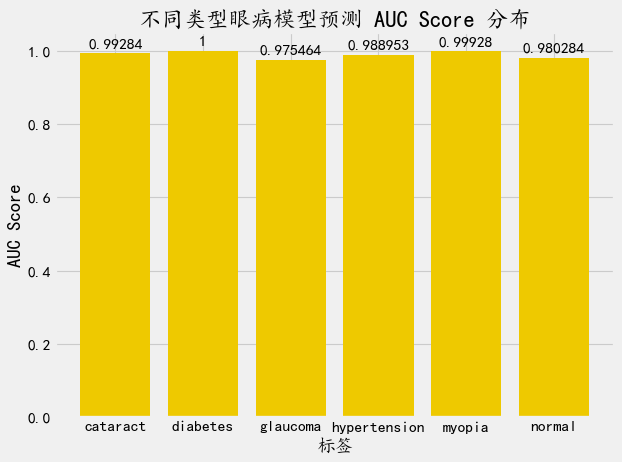

In [23]:
# 获取疾病标签名称列表
# 创建一个范围，表示 x 轴上每个标签的位置
x = np.arange(len(class_names))
# 设置柱状图的宽度
width = 0.80
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)
rects = ax.bar(x, cate_auc, width, color='#EEC900')
ax.set_ylabel('AUC Score')
ax.set_xlabel('标签')
ax.set_title('不同类型眼病模型预测 AUC Score 分布')
ax.set_xticks(x, class_names)
ax.bar_label(rects, padding=3)
fig.tight_layout()
plt.show()

### 绘制混淆矩阵

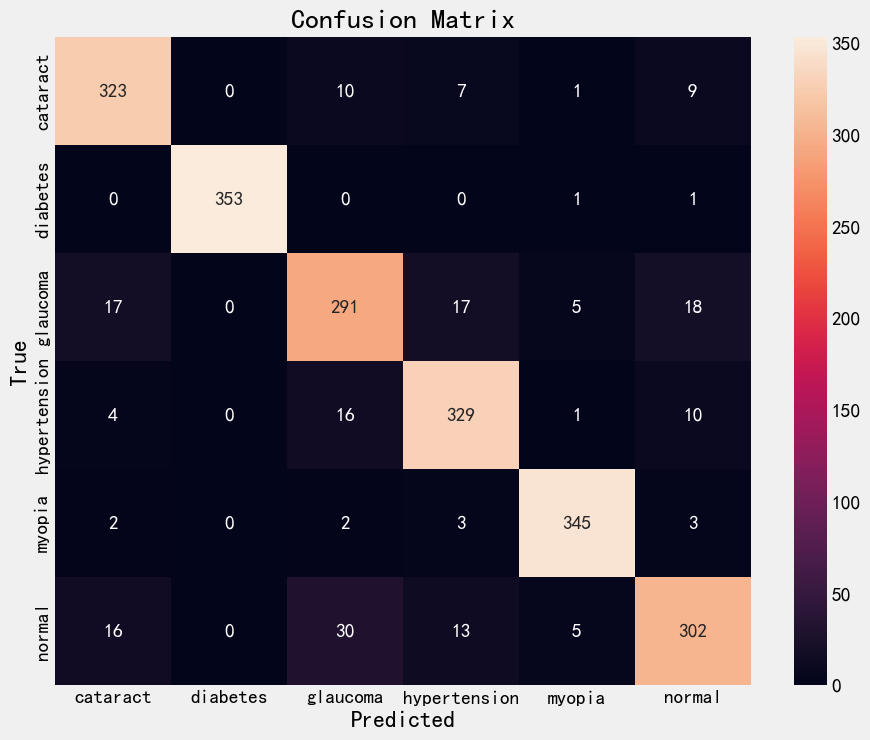

In [24]:
from sklearn.metrics import confusion_matrix

# 获取验证集的预测结果
y_pred = np.argmax(pred_test, axis=1)
y_true = np.argmax(val_labels, axis=1)

# 绘制混淆矩阵
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()